# Problem statement : **Stock Movement Prediction - Sentiment Enhanced Knowledge Graph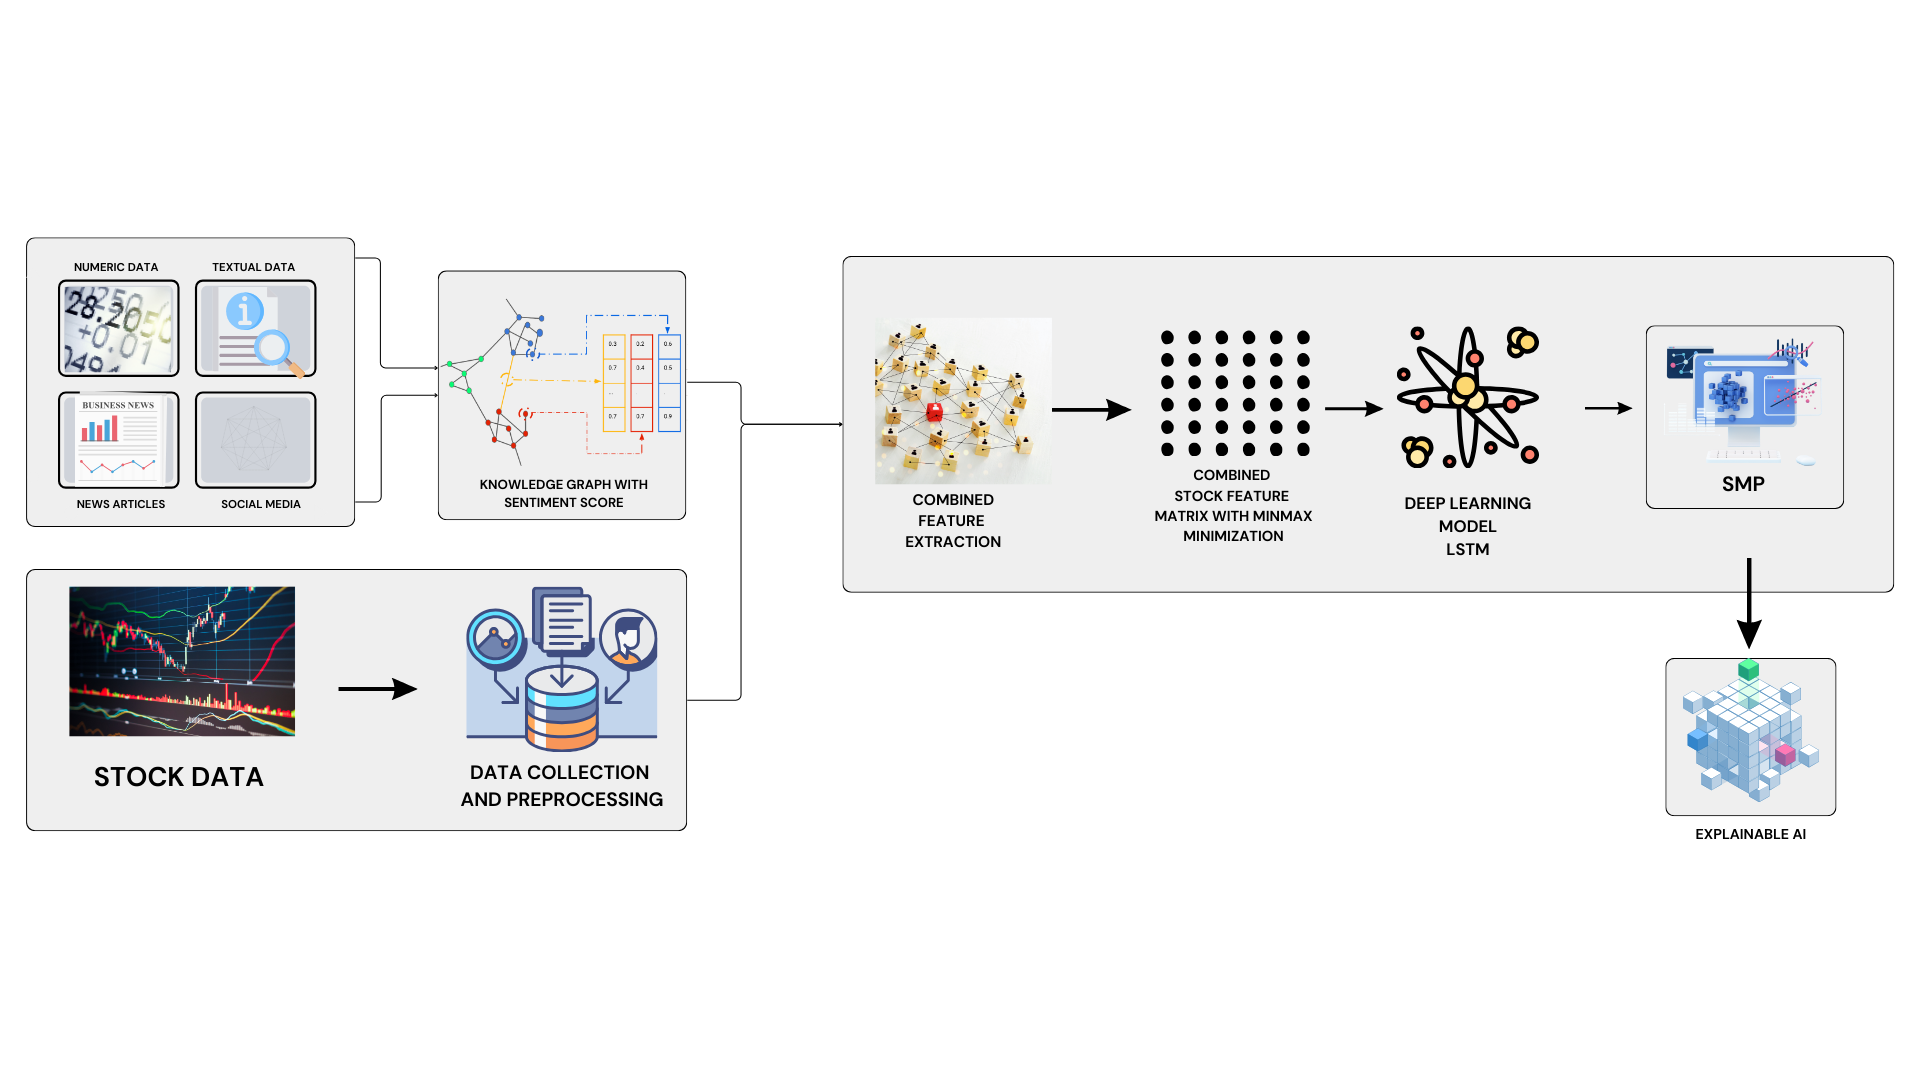

# Import Libraries
This cell imports all the necessary libraries required for the project. Key libraries include:
NLTK downloads the required datasets for tokenization and stopwords, while SpaCy loads a language model for entity recognition, essential in building a knowledge graph from news data.

In [ ]:
# Import libraries for data handling, stock data collection, and NLP
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import spacy
import networkx as nx
from transformers import pipeline
import requests


# Load SpaCy model and FinBERT
nlp = spacy.load('en_core_web_sm')
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")



# Data Collection: Stock Prices and News Data
load_stock_data: This function fetches historical stock data from Yahoo Finance using a stock ticker, start date, and end date. It returns a DataFrame with stock information over the specified period.
fetch_news_data: This function retrieves news articles for a given company using the NewsAPI. It collects the article title, description, URL, and publication date. The API key is required to authenticate requests.
Additional Notes: This cell prepares both stock and news data, allowing the project to capture trends in stock prices and relevant sentiment from recent news.


In [ ]:
# Function to load historical stock data from Yahoo Finance
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)

    # Add technical indicators
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = calculate_rsi(data['Close'])

    return data
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to fetch news data for a company (using NewsAPI)
def fetch_news_data(company_name, api_key):
    url = f'https://newsapi.org/v2/everything?q={company_name}&apiKey={api_key}'
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"Error fetching news: {response.status_code} - {response.text}")

    articles = response.json().get('articles', [])
    news_data = []
    for article in articles:
        news_data.append({
            'title': article['title'],
            'description': article['description'],
            'url': article['url'],
            'publishedAt': article['publishedAt'],
        })

    return news_data


# Data Preprocessing: Stock and Text Data
Explanation: This cell includes preprocessing functions for both stock and news data.

preprocess_stock_data: Cleans stock data by removing any missing values, ensuring consistency for model training.
preprocess_text: Cleans news text by tokenizing, converting to lowercase, and removing non-alphabet characters and stopwords. This helps retain only the meaningful words in the text, making it ready for sentiment analysis and entity extraction.
Additional Notes: Preprocessing is crucial as it prepares raw data for analysis and model training, making it cleaner and more informative

In [ ]:
# Function to preprocess stock data by removing NaN values
def preprocess_stock_data(data):
    return data.dropna()

# Function to preprocess news text by tokenizing and removing stopwords
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)


# Knowledge Graph Construction using FinBERT
This cell builds a knowledge graph from news data while performing sentiment analysis.
The knowledge graph captures relationships and sentiment from news articles, providing contextual insights for stock predictions by linking related entities and their associated sentiment.

In [ ]:
def build_knowledge_graph(news_data, nlp):
    G = nx.Graph()

    for article in news_data:
        title = article.get('title', '')
        description = article.get('description', '')
        text = (title + ' ' + description).strip()

        if not text:
            continue

        # Extract entities using spaCy model
        doc = nlp(text)
        # Filter entities to include common financial ones
        finance_entities = [ent.text for ent in doc.ents if ent.label_ in {"ORG", "MONEY", "GPE", "PERSON"}]

        # Perform sentiment analysis on the entire text
        sentiment = finbert(text)[0]

        # Add nodes and edges to the graph with sentiment data
        G.add_nodes_from(finance_entities)
        for i in range(len(finance_entities)):
            for j in range(i + 1, len(finance_entities)):
                if G.has_edge(finance_entities[i], finance_entities[j]):
                    G[finance_entities[i]][finance_entities[j]]['weight'] += 1
                else:
                    G.add_edge(finance_entities[i], finance_entities[j], weight=1)

                # Add sentiment attributes to the edge
                G[finance_entities[i]][finance_entities[j]]['sentiment'] = sentiment['label']
                G[finance_entities[i]][finance_entities[j]]['sentiment_score'] = sentiment['score']

    return G

# Graph Feature Extraction
This cell extracts features from the knowledge graph that are later used as inputs for the LSTM model.

extract_graph_features: This function calculates features from the knowledge graph such as the number of nodes, edges, average degree, density, and clustering coefficient. These features summarize the graph's structure and sentiment relationships, adding valuable context.
Additional Notes: The graph features add high-level information about market sentiment and its complexity, enhancing the predictive model with additional insights.

In [ ]:
def extract_graph_features(G):
    features = {
        'num_nodes': len(G.nodes()),
        'num_edges': len(G.edges()),
        'avg_degree': sum(dict(G.degree()).values()) / len(G.nodes()) if len(G.nodes()) > 0 else 0,
        'density': nx.density(G),
        'clustering_coefficient': nx.average_clustering(G) if len(G.nodes()) > 2 else 0,
    }
    return features


## Load Data And Visualization of Historical Stock data
 This cell loads the stock data and news data for further analysis.
 This cell establishes the project's main data sources, preparing the data needed for both the predictive model and the sentiment-based knowledge graph.

[*********************100%***********************]  1 of 1 completed


Stock Data Head:


,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI
Date,,,,,,,,,
2020-01-01,2168.000000,2183.899902,2154.000000,2167.600098,1975.473511,1354908,NaN,NaN,NaN
2020-01-02,2179.949951,2179.949951,2149.199951,2157.649902,1966.405151,2380752,NaN,NaN,NaN
2020-01-03,2164.000000,2223.000000,2164.000000,2200.649902,2005.593750,4655761,NaN,NaN,NaN
2020-01-06,2205.000000,2225.949951,2187.899902,2200.449951,2005.411987,3023209,NaN,NaN,NaN
2020-01-07,2200.500000,2214.649902,2183.800049,2205.850098,2010.333252,2429317,NaN,NaN,NaN


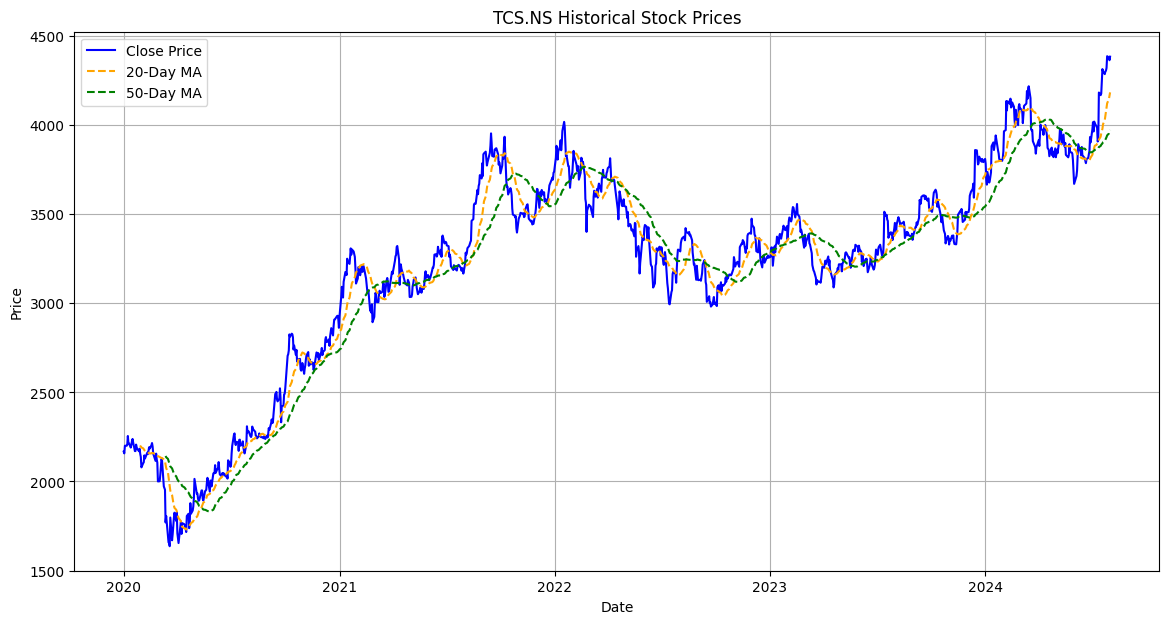

In [ ]:
# Set parameters
ticker = 'TCS.NS'
company_name = "TATA CONSULTANCY SERVICES"
start_date = '2020-01-01'
end_date = '2024-08-01'
news_api_key = 'b612ef2a5cdd4dfba512843742567f29'  # Replace with your API key

# Load stock data and news data
stock_data = load_stock_data(ticker, start_date, end_date)
news_data = fetch_news_data(company_name, news_api_key)

# Build knowledge graph and extract features
knowledge_graph = build_knowledge_graph(news_data, nlp)
graph_features = extract_graph_features(knowledge_graph)

# Display stock data
print("Stock Data Head:")
display(stock_data.head())

# Plot historical stock prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['MA20'], label='20-Day MA', color='orange', linestyle='--')
plt.plot(stock_data['MA50'], label='50-Day MA', color='green', linestyle='--')
plt.title(f'{ticker} Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



# Add Features and Scale Data
This cell prepares the stock data for use in the LSTM model.

Graph features from the previous cell are added as new columns in processed_stock_data.
Data Scaling: The MinMaxScaler is applied to the selected features (including stock price and graph features) to scale them to a range between 0 and 1, which is crucial for optimizing LSTM model training.
Creating Sequences: 60-day sequences are created from the scaled data to allow the LSTM model to learn from past trends and predict the next data point.
Additional Notes: This cell organizes the data into sequences and scales it, ensuring the LSTM model receives data in a format it can efficiently learn from.



In [ ]:
# Add graph features to stock data
for feature, value in graph_features.items():
    stock_data[feature] = value

# Select features for prediction
features = ['Close', 'Volume', 'num_nodes', 'num_edges', 'avg_degree', 'density', 'clustering_coefficient']
dataset = stock_data[features].dropna().values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Prepare sequences
sequence_length = 300
X, y = [], []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length, 0])

X, y = np.array(X), np.array(y)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Define and Train the LSTM Model
This cell defines and trains the LSTM model for predicting future stock prices.

create_lstm_model: This function defines an LSTM model architecture with four LSTM layers and a final Dense layer for output. Dropout layers are used between LSTM layers to prevent overfitting.
Model Training: The model is trained on X_train and y_train with 50 epochs and a batch size of 32. The validation_split parameter reserves 10% of the data for validation to monitor performance.
Additional Notes: The LSTM model is designed to capture long-term dependencies in stock prices and sentiment features, making it suitable for time series forecasting.



In [ ]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(150, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='huber')
    return model

# Train model
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
19/19 [==============================] - 11s 334ms/step - loss: 0.0292 - val_loss: 0.0022
Epoch 2/50
19/19 [==============================] - 5s 285ms/step - loss: 0.0045 - val_loss: 7.2761e-04
Epoch 3/50
19/19 [==============================] - 6s 305ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 4/50
19/19 [==============================] - 5s 280ms/step - loss: 0.0027 - val_loss: 5.6130e-04
Epoch 5/50
19/19 [==============================] - 5s 281ms/step - loss: 0.0028 - val_loss: 6.9808e-04
Epoch 6/50
19/19 [==============================] - 5s 281ms/step - loss: 0.0027 - val_loss: 6.9876e-04
Epoch 7/50
19/19 [==============================] - 5s 283ms/step - loss: 0.0022 - val_loss: 5.2064e-04
Epoch 8/50
19/19 [==============================] - 5s 287ms/step - loss: 0.0021 - val_loss: 5.8469e-04
Epoch 9/50
19/19 [==============================] - 6s 299ms/step - loss: 0.0020 - val_loss: 6.7129e-04
Epoch 10/50
19/19 [==============================] - 5s 286ms/step - lo

# Future Prediction and Evaluation
This cell makes predictions on the test data and evaluates the model's performance.

Predictions: Predictions are made on X_test data and inverse-scaled to match the original scale of stock prices.
Evaluation: The actual and predicted prices are compared using Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²) metrics, which provide insights into model accuracy.
Additional Notes: This final cell evaluates the effectiveness of the LSTM model in predicting future stock prices, with error metrics indicating the model's accuracy and performance.bold text

In [ ]:
def predict_future_prices(model, last_sequence, scaler, days_ahead=60):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days_ahead):
        next_day_price = model.predict(current_sequence)[0, 0]  # Get predicted close price

        future_predictions.append(next_day_price)

        # Update the sequence by shifting and adding the predicted price
        new_row = current_sequence[0, -1, :].copy()
        new_row[0] = next_day_price  # Update only the close price

        # Update sequence (shift left and add new row)
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, :] = new_row

    # Prepare predictions for inverse scaling
    future_pred_2d = np.zeros((len(future_predictions), len(features)))  # 2D array with same number of features
    future_pred_2d[:, 0] = future_predictions  # Predicted close price in the first column

    # Use the last row's other feature values for the rest of the columns
    last_known_row = current_sequence[0, -1, 1:]  # Get the last known values of other features
    future_pred_2d[:, 1:] = last_known_row  # Set the remaining columns

    # Inverse transform the predictions
    future_prices = scaler.inverse_transform(future_pred_2d)[:, 0]  # Only take the 'Close' prices

    return future_prices

# Example usage
last_sequence = X[-1:]
future_prices = predict_future_prices(model, last_sequence, scaler, days_ahead=60)


1/1 [==============================] - 0s 42ms/step


# Plot Historical and Predicted Prices

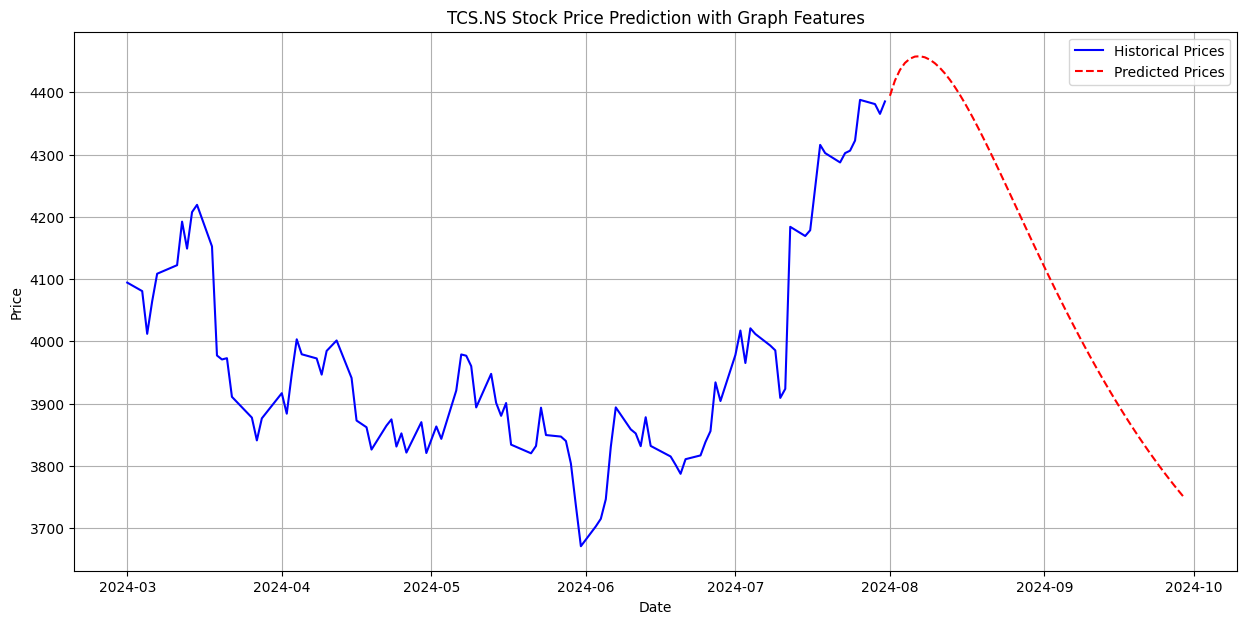

In [ ]:
# Plot results
plt.figure(figsize=(15, 7))

# Plot historical data
historical_dates = stock_data.index[-100:]  # Last 100 historical prices
historical_prices = stock_data['Close'].iloc[-100:]
plt.plot(historical_dates, historical_prices, label='Historical Prices', color='blue')

# Plot predictions
if len(future_prices) > 0:
    future_dates = pd.date_range(start=stock_data.index[-1], periods=61)[1:]  # 60 days ahead
    plt.plot(future_dates, future_prices, label='Predicted Prices', color='red', linestyle='--')

# Title and labels
plt.title(f'{ticker} Stock Price Prediction with Graph Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Model evaluation

In [ ]:
# Test set predictions
test_predictions = model.predict(X_test)

# Prepare arrays for inverse scaling
test_predictions_2d = np.zeros((len(test_predictions), len(features)))
test_predictions_2d[:, 0] = test_predictions.flatten()
y_test_2d = np.zeros((len(y_test), len(features)))
y_test_2d[:, 0] = y_test

# Inverse transform
test_predictions = scaler.inverse_transform(test_predictions_2d)[:, 0]
actual_values = scaler.inverse_transform(y_test_2d)[:, 0]

# Calculate metrics
mape = mean_absolute_percentage_error(actual_values, test_predictions)
r2 = r2_score(actual_values, test_predictions)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")
print(f"R² Score: {r2:.4f}")

print("\nGraph Features Used in Prediction:")
for feature, value in graph_features.items():
    print(f"{feature}: {value:.4f}")


6/6 [==============================] - 0s 78ms/step

Model Performance Metrics:
Mean Absolute Percentage Error: 2.42%
R² Score: 0.5936

Graph Features Used in Prediction:
num_nodes: 207.0000
num_edges: 1051.0000
avg_degree: 10.1546
density: 0.0493
clustering_coefficient: 0.8752


# Future Price Predictions

In [ ]:
print("\nFuture Price Predictions (next 60 days):")
for i in range(0, len(future_prices), 10):
    print(f"Day {i + 1}: {future_prices[i]:.2f}")



Future Price Predictions (next 60 days):
Day 1: 4394.38
Day 11: 4439.41
Day 21: 4305.91
Day 31: 4135.80
Day 41: 3977.93
Day 51: 3845.54


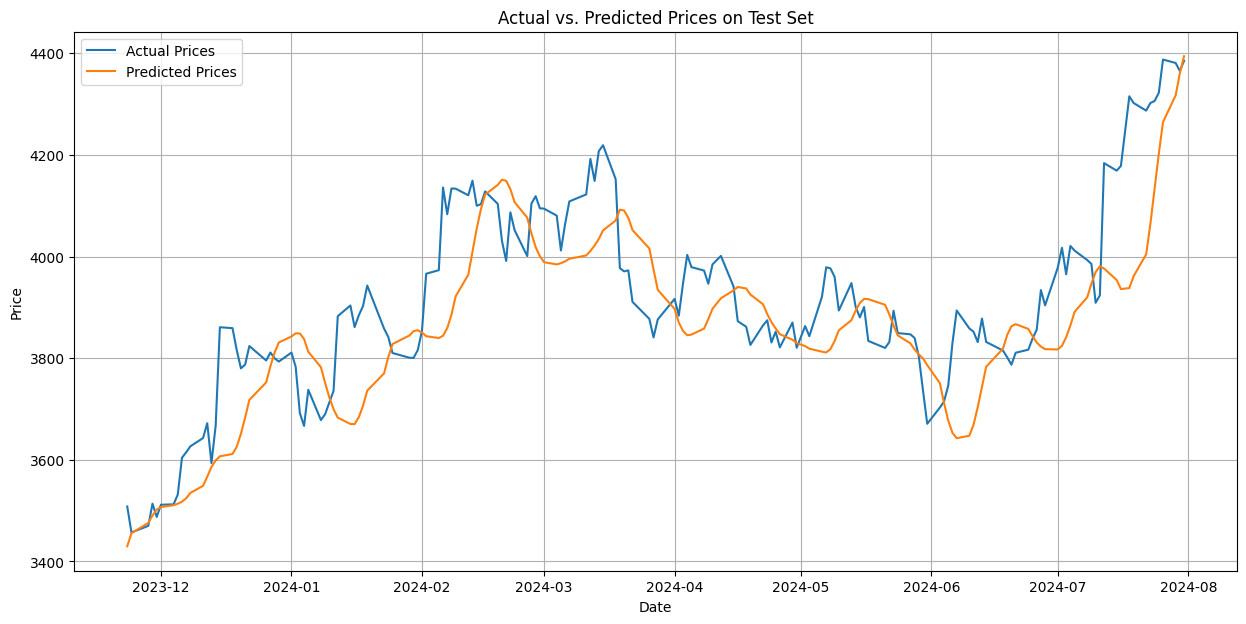

In [ ]:
# Plot actual vs. predicted prices on the test set
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index[-len(actual_values):], actual_values, label='Actual Prices')
plt.plot(stock_data.index[-len(test_predictions):], test_predictions, label='Predicted Prices')
plt.title('Actual vs. Predicted Prices on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

##Implementing SHAP to find out which features are most affecting our model's performance.
Shap itterates multiple times by altering the data in the lstm model and from the outputs difference it tells use which feature is influencing the lstm model, This helps us in hyperparameter tuning of the lstm model

In [ ]:
pip install shap


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Flatten the 3D array to 2D array for SHAP
X_test_shap_flat = X_test_shap.reshape(X_test_shap.shape[0], -1)


In [ ]:
import shap
import numpy as np


# Assuming X_test and time_steps are defined
# Reshape X_test for SHAP (use the last time_steps if applicable)
X_test_shap = X_test[:, -time_steps:, :]  # This keeps the last 'time_steps' for SHAP analysis

# Flatten the 3D array to a 2D array for SHAP
X_test_shap_flat = X_test_shap.reshape(X_test_shap.shape[0], -1)

# Sample a smaller subset from the training data for background
K = 10  # Set the number of samples you want to use
X_train_shap_sample = shap.sample(X_train.reshape(X_train.shape[0], -1), K)

# Initialize SHAP explainer using the model's predict method
# We need to ensure that the model is called with the correct input shape
explainer = shap.KernelExplainer(lambda x: model.predict(x.reshape(x.shape[0], time_steps, -1)), X_train_shap_sample)


# Generate SHAP values for the flattened test data
shap_values = explainer.shap_values(X_test_shap_flat)

# Plot feature importance using SHAP summary plot
shap.summary_plot(shap_values, X_test_shap_flat, feature_names=features)

# Show the plot
plt.show()
